<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Full_Test_Jacobians_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare Batched to Unbatched JJ





In [ ]:
Jdir =  '/content/drive/My Drive/J_resnets_fullsvd'

thismodel = 'resnet110_cifar10'
num_classes= 10
num_data = 50000

training = False
batched = False
start_batch = 0
batch_size = 100

device = 'cuda:0'


time: 3.15 ms


In [ ]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
time: 2.74 s


In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.41 s


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.05 ms


In [ ]:
!pip install pytorchcv
!pip install powerlaw
!pip install GPUtil
import GPUtil

time: 6.99 s


In [ ]:
!import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

import gc


/bin/bash: import: command not found
time: 652 ms


### Run InstallPhysTheory notebook 

In [ ]:
import sys
sys.path.append("/content/drive/My Drive/Jacobian")
import jacobian as jac
import utils

time: 1.69 ms


In [ ]:
def jacobian_full(model, data_loader, batch_size, num_classes=10, device='cuda:0'): 
  '''compute a full of J^{T}J Jacobian directly.  '''

  model.eval()
  model = model.to(device)

  J_right = jac.construct_diagJ(model, data_loader, batch_size=batch_size, device=device) 
  J_left = J_right.transpose(1,0)
  JJ = torch.mm(J_right, J_left)
  JJMat = JJ.detach().cpu().numpy()

  del J_right, J_left, JJ
  gc.collect()
  torch.cuda.empty_cache()

  return JJMat

time: 7.36 ms


### ResNet 

In [ ]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

time: 908 µs


### Compute JJ, in batches or all at once


In [ ]:
def get_datasets(thismodel, batch_size):
  print("getting dataset for ", thismodel)
  if thismodel.endswith('cifar100'):
    print("loading cifar100")
    train_dataset = datasets.CIFAR100(
      root='data', 
      train=True, 
      transform=transforms.ToTensor(),
      download=True)
    test_dataset = datasets.CIFAR100(
      root='data', 
      train=False, 
      transform=transforms.ToTensor(),
      download=True) 
 
    train_loader = DataLoader(
      dataset=train_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)
    test_loader = DataLoader(
      dataset=test_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)

  else:
    print("loading cifar10")
    train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

      
  return train_dataset, test_dataset, train_loader, test_loader

time: 9.38 ms


In [ ]:
print(thismodel)
train_dataset, test_dataset, train_loader, test_loader = get_datasets(thismodel, batch_size)#utils.get_data(batch_size=batch_size)

print(train_dataset)
GPUtil.showUtilization()


resnet110_cifar10
getting dataset for  resnet110_cifar10
loading cifar10
Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
           )
| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |
time: 1.83 s


In [ ]:
model = ptcv_get_model(thismodel, pretrained=True)  

#jacobian_batched_full(thismodel, model, test_loader, batch_size=batch_size, num_classes=num_classes, start_batch=start_batch)

#JJMat_true = jacobian_full(model, test_loader, batch_size=batch_size, num_classes=num_classes)

time: 254 ms


In [ ]:
dataset = "training" if training else "test"


if batched:
  print("Reading batched JJBlocks for ", thismodel)
  JJMat = None
  import os, glob
  os.chdir(Jdir)
  for filename in glob.glob("Jfull_{}__*.csv".format(thismodel)):
    print(filename)
    JJBlock = np.loadtxt(filename)
    JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock

else:
  data_loader = train_loader if training else test_loader
  print("Recomputing {} full JJMat directly using {} dataset".format(thismodel, dataset))
  JJMat = jacobian_full(model, data_loader, batch_size=batch_size, num_classes=num_classes)


Recomputing resnet110_cifar10 full JJMat directly using test dataset
time: 57.3 s


In [ ]:
type(JJMat)

numpy.ndarray

time: 2.4 ms


In [ ]:
import powerlaw

time: 752 µs


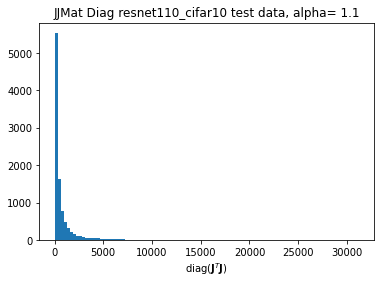

alpha, D, xmin
1.097525984142405 0.5095819610684401 0.01


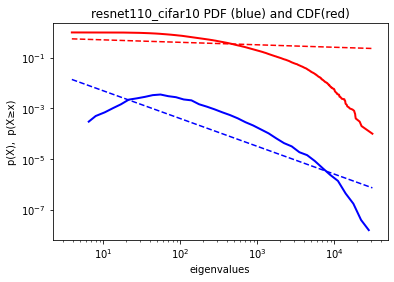

time: 679 ms


In [ ]:
JJDiag = np.diag(JJMat)
fit = powerlaw.Fit(JJDiag, xmin=0.01)
alpha = fit.alpha
D = fit.D
xmin = fit.xmin

dataset = "training" if training else "test"


plt.hist(JJDiag, bins=100);
plt.title("JJMat Diag {} {} data, alpha= {:2.2}".format(thismodel, dataset, alpha))
plt.xlabel(r"diag$(\mathbf{J}^{T}\mathbf{J})$")
plt.show()

print("alpha, D, xmin")
print(alpha, D, xmin)

fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)

plt.title("{} PDF (blue) and CDF(red)".format(thismodel))

fig2.set_ylabel(u"p(X),  p(X≥x)")
fig2.set_xlabel(r"eigenvalues")

plt.show()


In [ ]:
norm = num_classes*3*32*32 
evals = np.linalg.eigvalsh(JJMat)
evals  = (1.0/ norm)*evals

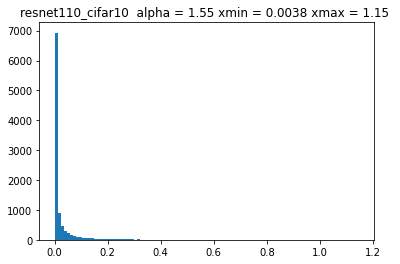

1.5530782078232277 0.1013037619343875 1.1466715


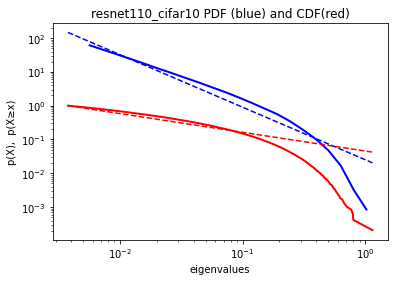

Assuming nested distributions
Assuming nested distributions


exponential 786.1778822654984 2.5162783699825157e-22
lognormal_positive 3395749.460738055 0.0
time: 3.11 s


No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


In [ ]:
data = np.log10(evals[evals>0])
mu = np.mean(data)
xmin = 10**mu

fit = powerlaw.Fit(evals, xmin=xmin)
alpha = fit.alpha
D = fit.D
max_eval = np.max(evals)

plt.hist(evals, bins=100)
plt.title("{}  alpha = {:0.2f} xmin = {:0.2} xmax = {:0.2f} ".format(thismodel, alpha, xmin, max_eval))
plt.show()

print(alpha, D, max_eval)


fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)

plt.title("{} PDF (blue) and CDF(red)".format(thismodel))

fig2.set_ylabel(u"p(X),  p(X≥x)")
fig2.set_xlabel(r"eigenvalues")

plt.show()


for distname, _ in fit.supported_distributions.items():
  R, p = fit.distribution_compare('power_law', distname)
  if R > 0.0:
    print(distname,R, p)


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


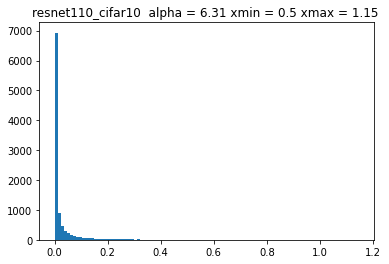

6.3098501388184385 0.061991723689284794 1.1466715


/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


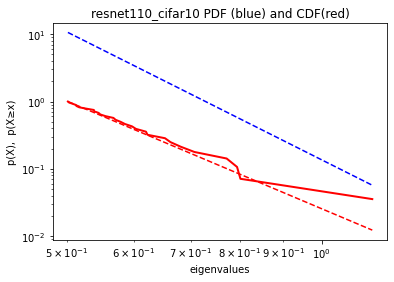

exponential 0.3113364272021088 0.722984217206718
stretched_exponential 0.0002835089194683227 0.9991302246141331
lognormal_positive 19825.821060285678 0.0
time: 14.8 s


Assuming nested distributions
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions
No valid fits found.


In [ ]:


fit = powerlaw.Fit(evals)
alpha = fit.alpha
D = fit.D
max_eval = np.max(evals)
xmin = fit.xmin

plt.hist(evals, bins=100)
plt.title("{}  alpha = {:0.2f} xmin = {:0.2} xmax = {:0.2f} ".format(thismodel, alpha, xmin, max_eval))
plt.show()

print(alpha, D, max_eval)


fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)

plt.title("{} PDF (blue) and CDF(red)".format(thismodel))

fig2.set_ylabel(u"p(X),  p(X≥x)")
fig2.set_xlabel(r"eigenvalues")

plt.show()

for distname, _ in fit.supported_distributions.items():
  R, p = fit.distribution_compare('power_law', distname)
  if R > 0.0:
    print(distname,R, p)

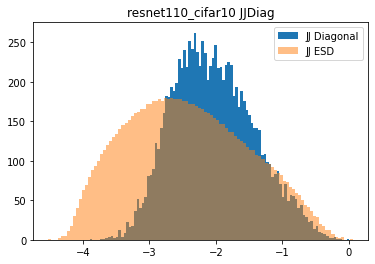

time: 536 ms


In [ ]:
  R, p = fit.distribution_compare('power_law', 'lognormal')
  print(R,p)
  if R > 0.0:
    print('log normal?',R, p)

  R, p = fit.distribution_compare('power_law', 'truncated_power_law')
  print(R,p)

  if R > 0.0:
    print('truncated_power_law?',R, p)plt.hist(np.log10(JJDiag/(10*3*32*32)), bins=100, label='JJ Diagonal');
plt.hist(np.log10(evals), bins=100, alpha=0.5, label='JJ ESD');

plt.title("{} JJDiag".format(thismodel))
plt.legend()

In [ ]:
np.max(evals)*10

11.466715335845947

time: 2.33 ms


2.0


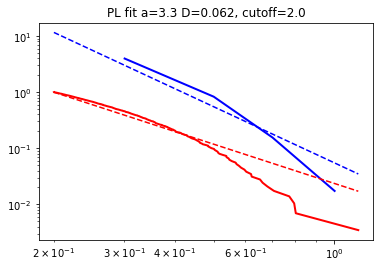

alpha, D 3.330117905003922 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 204588.82725706158 0.0
1.9


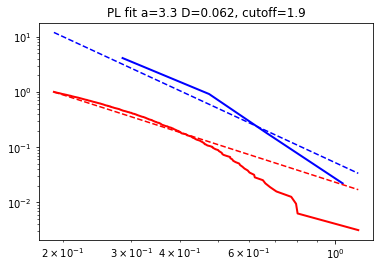

alpha, D 3.2649605964910307 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 223706.00745339846 0.0
1.8


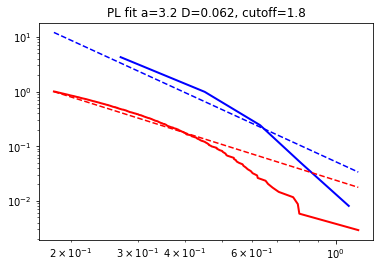

alpha, D 3.17974793040069 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 242819.59986362795 0.0
1.7


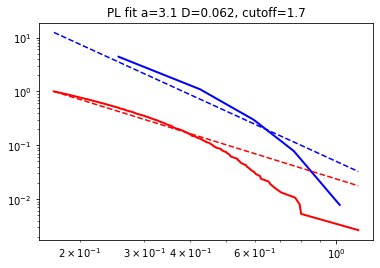

alpha, D 3.1135837247804017 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 266185.7540664197 0.0
1.6


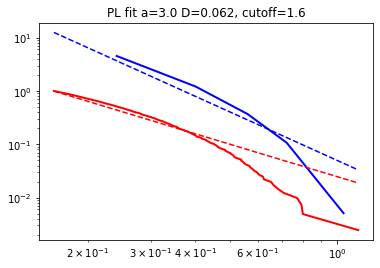

alpha, D 3.01881201960228 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 288128.88298308925 0.0
1.5


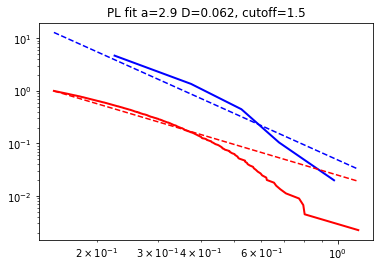

alpha, D 2.9466619353529566 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 315742.649240958 0.0
1.4


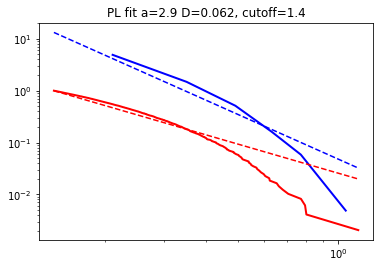

alpha, D 2.863890742385438 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 344769.64861084765 0.0
1.3


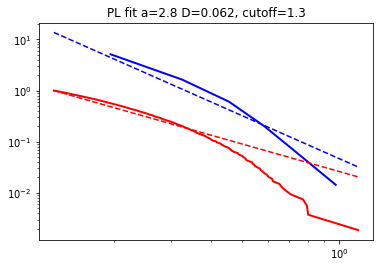

alpha, D 2.785012074591776 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 378046.9283034223 0.0
1.2


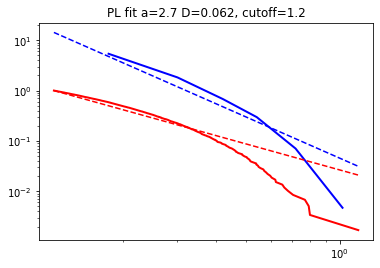

alpha, D 2.711610949461187 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 416992.60845279315 0.0
1.1


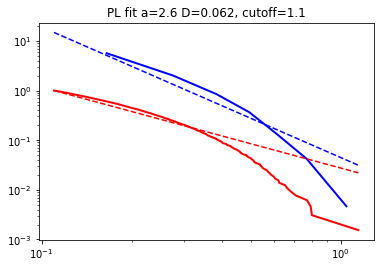

alpha, D 2.628344528282148 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 458767.3734114541 0.0
1.0


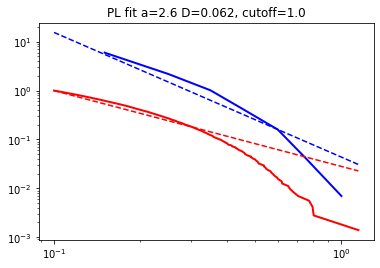

alpha, D 2.552620596807806 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 509046.30588006706 0.0
0.9


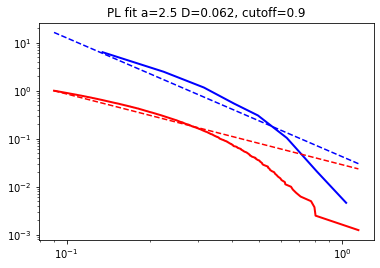

alpha, D 2.4730177383799576 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 566408.0031095513 0.0
0.8


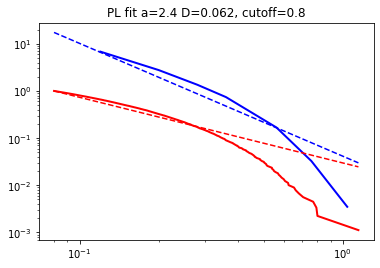

alpha, D 2.392190642029875 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 633688.5847525306 0.0
0.7


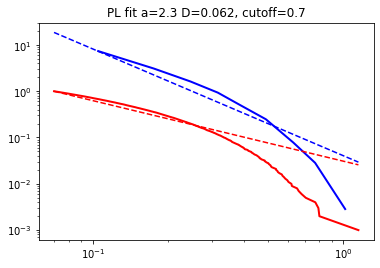

alpha, D 2.3105220700328344 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 714432.7967801474 0.0
0.6


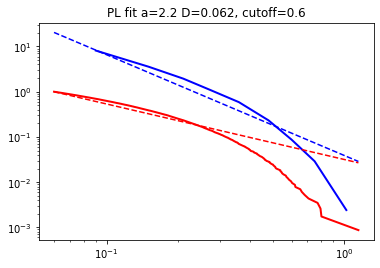

alpha, D 2.226431385052943 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 812893.9429506438 0.0
0.5


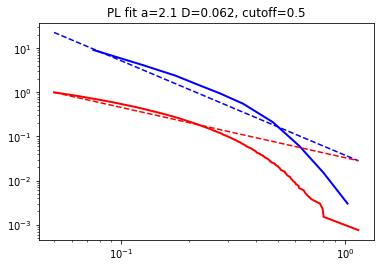

alpha, D 2.1380812196134773 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 935452.976480032 0.0
0.4


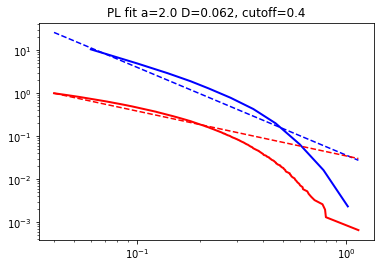

alpha, D 2.0440065063543136 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 1094165.472238057 0.0
0.3


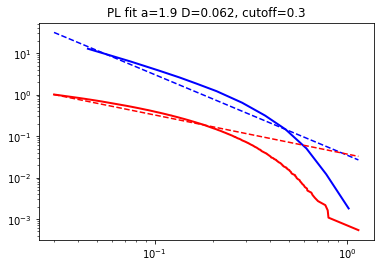

alpha, D 1.9419700791427092 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 1313148.8856209686 0.0
0.2


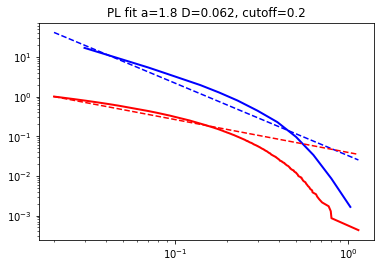

alpha, D 1.829050492400716 0.061991723689284794


Assuming nested distributions
Assuming nested distributions
No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


lognormal_positive 1653433.5454151493 0.0
0.1


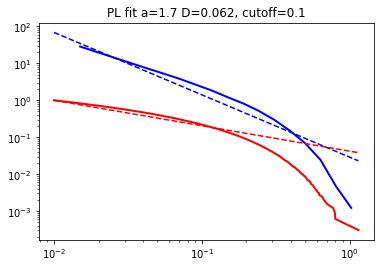

alpha, D 1.6884239216196169 0.061991723689284794
exponential 121.6712161867834 0.016729642725717295


Assuming nested distributions
Assuming nested distributions


lognormal_positive 2316651.546436841 0.0
time: 21 s


No valid fits found.
/usr/local/lib/python3.6/dist-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


In [ ]:
alphas = []
Ds = []
xmin = 10**mu

cutoffs =  [2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

for max_eval in cutoffs:
  xmin = max_eval / 10.0
  print(max_eval)
  fit = powerlaw.Fit(evals,  xmin=xmin)
  alpha = fit.alpha

  alphas.append(alpha)
  Ds.append(D)
  
  fig2 = fit.plot_pdf(color='b', linewidth=2)
  fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
  fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
  fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
  plt.title("PL fit a={:2.2} D={:2.2}, cutoff={:2.2}".format(alpha, D, max_eval))
  plt.show()


  print("alpha, D", alpha, D)
  for distname, _ in fit.supported_distributions.items():
    R, p = fit.distribution_compare('power_law', distname)
    if R > 0.0:
      print(distname,R, p)

Text(0, 0.5, '$\\alpha$ PL expoment')

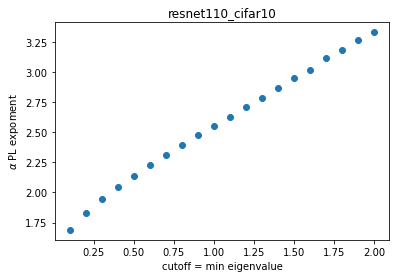

time: 179 ms


In [ ]:
plt.scatter(cutoffs, alphas)
plt.title(thismodel)
plt.xlabel('cutoff = min eigenvalue')
plt.ylabel(r"$\alpha$ PL expoment")

Text(0, 0.5, '$D$ ')

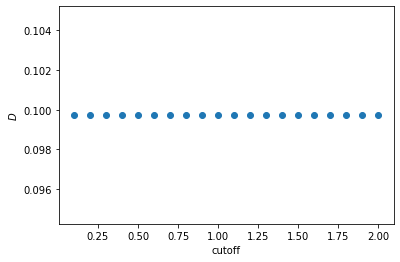

time: 159 ms


In [ ]:
plt.scatter(cutoffs, Ds)

plt.xlabel('cutoff')
plt.ylabel(r"$D$ ")